# House Price Prediction Project
## Ben Belnap (003177064)

This notebook implements a machine learning solution to predict house prices using the Ames Housing Dataset. The project follows the CRISP-DM methodology and aims to provide accurate home value estimates for a mortgage company.

## 1. Setup and Required Libraries

Import all necessary libraries for data analysis, modeling, and visualization.

In [164]:
# Setup Python path
import os
import sys
notebook_dir = os.path.abspath(os.getcwd())  # Get the notebook's directory
project_root = os.path.dirname(notebook_dir)  # Get the project root directory
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"Added to Python path: {project_root}")

# Data manipulation and analysis
import pandas as pd
import numpy as np
import polars as pl

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Custom modules
from src.data_preprocessing import check_data_quality, remove_outliers, prepare_data
from src.model_utils import get_default_models, debug_model_performance
from src.evaluation_utils import evaluate_model, plot_predictions

# Settings
plt.style.use('seaborn-v0_8')  
sns.set_theme()  # Using seaborn's default theme
%matplotlib inline

Added to Python path: d:\Repos\House-Price-Prediction-Machine-Learning


## 2. Data Understanding

In this section, we will load and explore the Ames Housing Dataset. We'll analyze its structure, generate summary statistics, and visualize key relationships.

In [165]:
# Load the dataset with error handling
try:
    df = pd.read_csv('../data/amesHousing.csv')
    # Drop PID and Order columns
    df = df.drop(['PID', 'Order'], axis=1)
    print("Dataset successfully loaded!")
    print("\nDataset Shape:", df.shape)
    print("\nFirst few rows:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    
    # Check for missing values
    missing_values = df.isnull().sum()
    print("\nColumns with missing values:")
    print(missing_values[missing_values > 0])
    
    # Display basic statistics
    print("\nNumerical columns statistics:")
    print(df.describe())
except FileNotFoundError:
    print("Error: Dataset file not found. Please make sure 'ames_housing.csv' is in the data directory.")
except pd.errors.EmptyDataError:
    print("Error: The dataset file is empty.")
except pd.errors.ParserError:
    print("Error: Unable to parse the CSV file. Please check if it's a valid CSV format.")
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")

Dataset successfully loaded!

Dataset Shape: (2930, 80)

First few rows:
   MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley Lot Shape  \
0           20        RL         141.0     31770   Pave   NaN       IR1   
1           20        RH          80.0     11622   Pave   NaN       Reg   
2           20        RL          81.0     14267   Pave   NaN       IR1   
3           20        RL          93.0     11160   Pave   NaN       Reg   
4           60        RL          74.0     13830   Pave   NaN       IR1   

  Land Contour Utilities Lot Config  ... Pool Area Pool QC  Fence  \
0          Lvl    AllPub     Corner  ...         0     NaN    NaN   
1          Lvl    AllPub     Inside  ...         0     NaN  MnPrv   
2          Lvl    AllPub     Corner  ...         0     NaN    NaN   
3          Lvl    AllPub     Corner  ...         0     NaN    NaN   
4          Lvl    AllPub     Inside  ...         0     NaN  MnPrv   

  Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  Sale Con

## 3. Data Preparation

Here we will clean the data, handle missing values, remove outliers, and prepare features for modeling.

In [166]:
# Data cleaning functions
check_data_quality(df)

=== Data Quality Report ===

Data Types:
object     43
int64      26
float64    11
Name: count, dtype: int64

Columns with missing values:
Lot Frontage       490
Alley             2732
Mas Vnr Type      1775
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64

Number of duplicate rows: 0

Checking numerical columns for invalid values...


{'missing': MS SubClass         0
 MS Zoning           0
 Lot Frontage      490
 Lot Area            0
 Street              0
                  ... 
 Mo Sold             0
 Yr Sold             0
 Sale Type           0
 Sale Condition      0
 SalePrice           0
 Length: 80, dtype: int64,
 'duplicates': np.int64(0)}

### Missing Value Analysis

Let's analyze our missing values in detail before deciding how to handle them:
1. Calculate the percentage of missing values per column
2. Understand the nature of missingness (Missing Completely at Random, Missing at Random, or Missing Not at Random)
3. Make informed decisions based on domain knowledge

Columns with missing values (sorted by percentage):
            Column  Missing %
71         Pool QC  99.556314
73    Misc Feature  96.382253
5            Alley  93.242321
72           Fence  80.477816
24    Mas Vnr Type  60.580205
56    Fireplace Qu  48.532423
2     Lot Frontage  16.723549
58   Garage Yr Blt   5.426621
62     Garage Qual   5.426621
63     Garage Cond   5.426621
59   Garage Finish   5.426621
57     Garage Type   5.358362
31   Bsmt Exposure   2.832765
34  BsmtFin Type 2   2.764505
29       Bsmt Qual   2.730375
32  BsmtFin Type 1   2.730375
30       Bsmt Cond   2.730375
25    Mas Vnr Area   0.784983
46  Bsmt Full Bath   0.068259
47  Bsmt Half Bath   0.068259
35    BsmtFin SF 2   0.034130
61     Garage Area   0.034130
37   Total Bsmt SF   0.034130
33    BsmtFin SF 1   0.034130
41      Electrical   0.034130
36     Bsmt Unf SF   0.034130
60     Garage Cars   0.034130


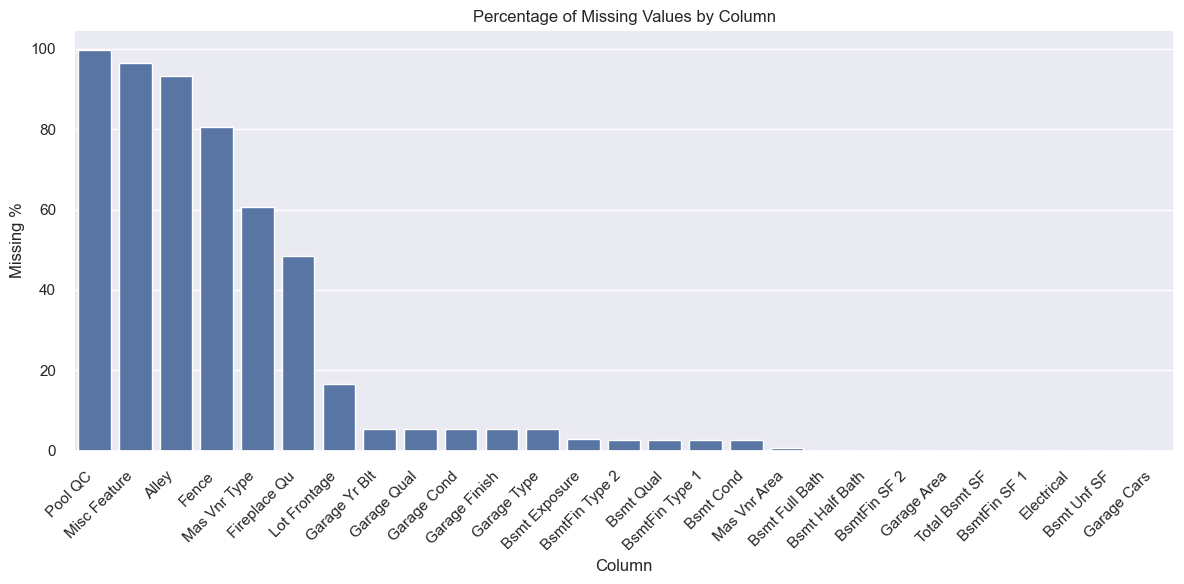


Recommended handling strategies:

Columns to consider dropping (>30% missing):
['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Mas Vnr Type', 'Fireplace Qu']

Columns needing careful consideration (10-30% missing):
['Lot Frontage']

Columns safe for standard imputation (<10% missing):
['Garage Yr Blt', 'Garage Qual', 'Garage Cond', 'Garage Finish', 'Garage Type', 'Bsmt Exposure', 'BsmtFin Type 2', 'Bsmt Qual', 'BsmtFin Type 1', 'Bsmt Cond', 'Mas Vnr Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'BsmtFin SF 2', 'Garage Area', 'Total Bsmt SF', 'BsmtFin SF 1', 'Electrical', 'Bsmt Unf SF', 'Garage Cars']

Analyzing relationship between missingness and Sale Price:

Lot Frontage:
Average Sale Price (missing): $184,263.44
Average Sale Price (not missing): $180,099.74
Difference: $4,163.70


In [167]:
# Calculate percentage of missing values per column
missing_percentages = (df.isnull().sum() / len(df)) * 100
missing_stats = pd.DataFrame({
    'Column': missing_percentages.index,
    'Missing %': missing_percentages.values
}).sort_values('Missing %', ascending=False)

print("Columns with missing values (sorted by percentage):")
print(missing_stats[missing_stats['Missing %'] > 0])

# Visualize missing value patterns
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_stats[missing_stats['Missing %'] > 0]['Column'],
            y=missing_stats[missing_stats['Missing %'] > 0]['Missing %'])
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Missing Values by Column')
plt.tight_layout()
plt.show()

# Define thresholds for different handling strategies
HIGH_MISSING = 30  # If more than 30% missing, consider dropping the column
MODERATE_MISSING = 10  # If between 10-30% missing, need careful consideration
LOW_MISSING = 5  # If less than 5% missing, can impute with median/mode

# Categorize columns based on missing percentages
high_missing_cols = missing_stats[missing_stats['Missing %'] > HIGH_MISSING]['Column'].tolist()
moderate_missing_cols = missing_stats[(missing_stats['Missing %'] <= HIGH_MISSING) & 
                                    (missing_stats['Missing %'] > MODERATE_MISSING)]['Column'].tolist()
low_missing_cols = missing_stats[(missing_stats['Missing %'] <= MODERATE_MISSING) & 
                                (missing_stats['Missing %'] > 0)]['Column'].tolist()

print("\nRecommended handling strategies:")
print(f"\nColumns to consider dropping (>{HIGH_MISSING}% missing):")
print(high_missing_cols)
print(f"\nColumns needing careful consideration ({MODERATE_MISSING}-{HIGH_MISSING}% missing):")
print(moderate_missing_cols)
print(f"\nColumns safe for standard imputation (<{MODERATE_MISSING}% missing):")
print(low_missing_cols)

# For numeric columns with moderate missing values, let's check if missingness is related to the target variable
print("\nAnalyzing relationship between missingness and Sale Price:")
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in [c for c in moderate_missing_cols if c in numeric_cols]:
    missing_mask = df[col].isnull()
    if missing_mask.any():
        avg_price_missing = df[missing_mask]['SalePrice'].mean()
        avg_price_not_missing = df[~missing_mask]['SalePrice'].mean()
        print(f"\n{col}:")
        print(f"Average Sale Price (missing): ${avg_price_missing:,.2f}")
        print(f"Average Sale Price (not missing): ${avg_price_not_missing:,.2f}")
        print(f"Difference: ${abs(avg_price_missing - avg_price_not_missing):,.2f}")

In [168]:
# Apply data preparation using our utility functions
def prepare_data(df):
    """Prepare data by handling missing values and outliers"""
    try:
        print("Starting data preparation...")
        
        # Remove outliers from the SalePrice column
        print("\nRemoving outliers from SalePrice...")
        original_size = len(df)
        df = remove_outliers(df, 'SalePrice', n_std=2.5)
        removed_count = original_size - len(df)
        print(f"Removed {removed_count} outliers ({(removed_count/original_size)*100:.2f}% of data)")
        
        # Handle missing values
        print("\nHandling missing values...")
        # For numerical columns, fill with median
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
        for col in numerical_cols:
            if df[col].isnull().sum() > 0:
                df[col] = df[col].fillna(df[col].median())
                
        # For categorical columns, fill with mode
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if df[col].isnull().sum() > 0:
                df[col] = df[col].fillna(df[col].mode()[0])
        
        # Verify no missing values remain
        remaining_missing = df.isnull().sum().sum()
        print(f"Remaining missing values: {remaining_missing}")
        
        print("\nData preparation completed!")
        
        # Display the shape of the cleaned dataset
        print(f"\nFinal dataset shape: {df.shape}")
        
        return df
            
    except Exception as e:
        print(f"Error during data preparation: {str(e)}")
        return None

df_cleaned = prepare_data(df.copy())

check_data_quality(df_cleaned)

Starting data preparation...

Removing outliers from SalePrice...
Removed 83 outliers (2.83% of data)

Handling missing values...
Remaining missing values: 0

Data preparation completed!

Final dataset shape: (2847, 80)
=== Data Quality Report ===

Data Types:
object     43
int64      26
float64    11
Name: count, dtype: int64

No missing values found!

Number of duplicate rows: 0

Checking numerical columns for invalid values...


{'missing': MS SubClass       0
 MS Zoning         0
 Lot Frontage      0
 Lot Area          0
 Street            0
                  ..
 Mo Sold           0
 Yr Sold           0
 Sale Type         0
 Sale Condition    0
 SalePrice         0
 Length: 80, dtype: int64,
 'duplicates': np.int64(0)}

## 4. Model Development

We will implement and train multiple models, including Random Forest and XGBoost.

In [169]:
# Initialize models using our utility function
models = get_default_models()

### Data Split and Feature Preparation

Before training our models, we need to:
1. Separate features (X) from target variable (y)
2. Split data into training and test sets
3. Scale numerical features to ensure all features contribute equally to the model

In [170]:
# Separate features and target
X = df_cleaned.drop('SalePrice', axis=1)  # All columns except SalePrice
y = df_cleaned['SalePrice']

# Get list of numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print("Feature Information:")
print(f"Numerical columns: {len(numerical_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print(f"\nShape after creating dummy variables: {X.shape}")

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # Use 80% for training, 20% for testing
    random_state=42  # For reproducibility
)

print("\nData Split Summary:")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set price statistics:")
print(y_train.describe())

Feature Information:
Numerical columns: 36
Categorical columns: 43

Shape after creating dummy variables: (2847, 260)

Data Split Summary:
Training set shape: (2277, 260)
Test set shape: (570, 260)

Training set price statistics:
count      2277.000000
mean     173352.102328
std       64497.411119
min       34900.000000
25%      128600.000000
50%      159500.000000
75%      208300.000000
max      380000.000000
Name: SalePrice, dtype: float64


In [171]:
# Model validation and debugging functions
from sklearn.metrics import mean_absolute_error, r2_score

def debug_model_performance(model, X_train, X_test, y_train, y_test, model_name):
    """Debug model performance and print detailed analysis"""
    print(f"=== {model_name} Debug Report ===")
    
    # Training performance
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Testing performance
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("\nPerformance Metrics:")
    print(f"Training MAE: ${train_mae:,.2f}")
    print(f"Testing MAE: ${test_mae:,.2f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    
    # Check for overfitting
    print("\nOverfitting Analysis:")
    mae_diff = abs(train_mae - test_mae)
    r2_diff = abs(train_r2 - test_r2)
    print(f"MAE difference (train-test): ${mae_diff:,.2f}")
    print(f"R² difference (train-test): {r2_diff:.4f}")
    
    if mae_diff > 10000 or r2_diff > 0.1:
        print("WARNING: Possible overfitting detected!")
        
    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        print("\nTop 10 Important Features:")
        importances = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        print(importances.head(10))
        
    print('\n')
    return {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

# Train each model
for model_name, model in models.items():
    model.fit(X_train, y_train)  
    # debug_model_performance(model, X_train, X_test, y_train, y_test, model_name)

## 5. Model Evaluation and Comparison

We will evaluate our models using comprehensive metrics and visualizations to demonstrate their effectiveness in predicting house prices.


Evaluating Random Forest...

=== Random Forest Performance Summary ===

Training Metrics:
MAE: $5,503.18
RMSE: $8,315.53
R²: 0.9834

Test Metrics:
MAE: $14,402.56
RMSE: $20,165.35
R²: 0.8947


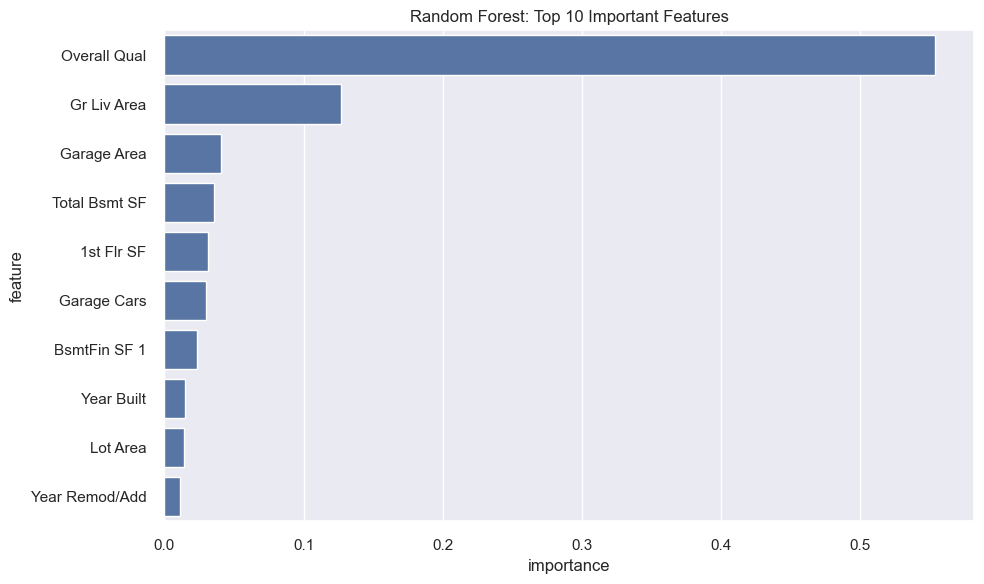

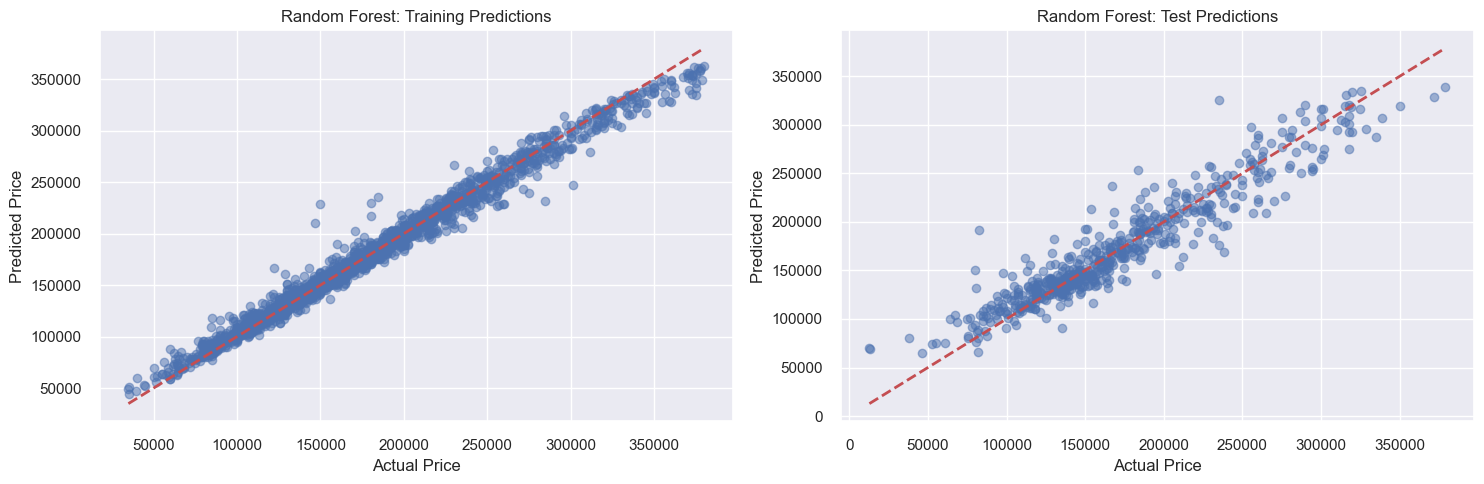


Evaluating XGBoost...

=== XGBoost Performance Summary ===

Training Metrics:
MAE: $2,094.73
RMSE: $2,850.57
R²: 0.9980

Test Metrics:
MAE: $13,477.84
RMSE: $18,829.71
R²: 0.9082


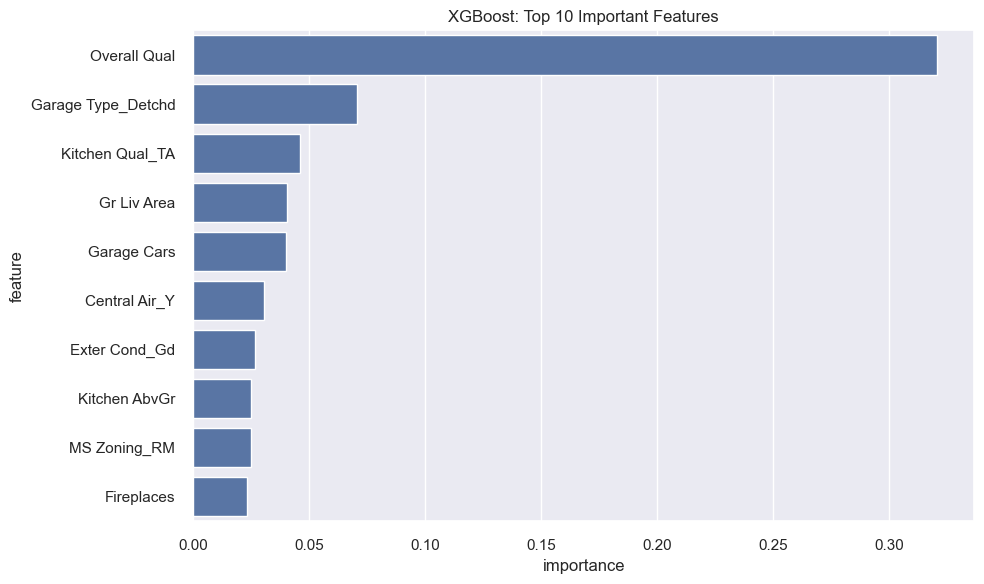

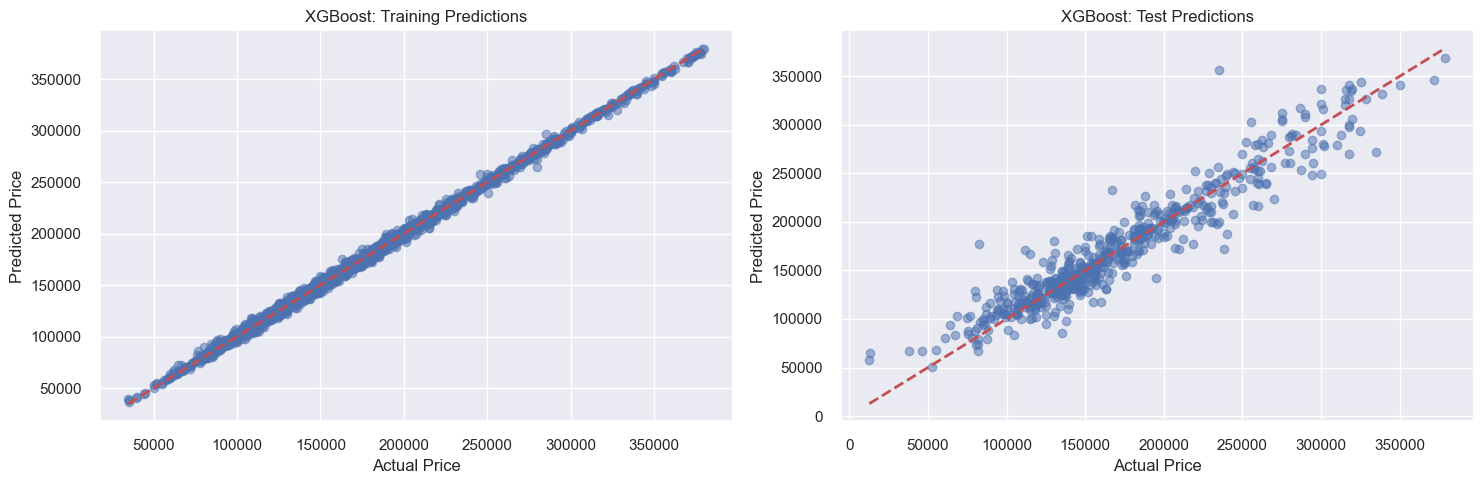

In [172]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

def evaluate_and_visualize_model(model, X_train, X_test, y_train, y_test, model_name):
    """Comprehensive model evaluation with metrics, feature importance, and visualization"""
    # Get predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'train': {
            'mae': mean_absolute_error(y_train, y_train_pred),
            'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'r2': r2_score(y_train, y_train_pred)
        },
        'test': {
            'mae': mean_absolute_error(y_test, y_test_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'r2': r2_score(y_test, y_test_pred)
        }
    }
    
    # Print metrics
    print(f"\n=== {model_name} Performance Summary ===")
    print("\nTraining Metrics:")
    print(f"MAE: ${results['train']['mae']:,.2f}")
    print(f"RMSE: ${results['train']['rmse']:,.2f}")
    print(f"R²: {results['train']['r2']:.4f}")
    
    print("\nTest Metrics:")
    print(f"MAE: ${results['test']['mae']:,.2f}")
    print(f"RMSE: ${results['test']['rmse']:,.2f}")
    print(f"R²: {results['test']['r2']:.4f}")
    
    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        importances = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        sns.barplot(data=importances, x='importance', y='feature')
        plt.title(f'{model_name}: Top 10 Important Features')
        plt.tight_layout()
        plt.show()
    
    # Prediction visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Training set predictions
    ax1.scatter(y_train, y_train_pred, alpha=0.5)
    ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual Price')
    ax1.set_ylabel('Predicted Price')
    ax1.set_title(f'{model_name}: Training Predictions')
    
    # Test set predictions
    ax2.scatter(y_test, y_test_pred, alpha=0.5)
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax2.set_xlabel('Actual Price')
    ax2.set_ylabel('Predicted Price')
    ax2.set_title(f'{model_name}: Test Predictions')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Evaluate all models
model_results = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    model_results[model_name] = evaluate_and_visualize_model(
        model, X_train, X_test, y_train, y_test, model_name
    )

In [173]:
import joblib
import os

# Create models directory if it doesn't exist
models_dir = os.path.join(project_root, 'models')
os.makedirs(models_dir, exist_ok=True)

# Save each model with its performance metrics
for model_name, model in models.items():
    # Save the model
    model_path = os.path.join(models_dir, f"{model_name.lower().replace(' ', '_')}.joblib")
    joblib.dump(model, model_path)
    
    # Save model metadata (performance metrics)
    metadata = {
        'metrics': model_results[model_name],
        'features': list(X_train.columns),
        'timestamp': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        'training_data_shape': X_train.shape,
        'test_data_shape': X_test.shape
    }
    metadata_path = os.path.join(models_dir, f"{model_name.lower().replace(' ', '_')}_metadata.joblib")
    joblib.dump(metadata, metadata_path)
    
    print(f"Saved {model_name} to {model_path}")
    print(f"Saved {model_name} metadata to {metadata_path}")

print("\nAll models have been saved successfully!")

Saved Random Forest to d:\Repos\House-Price-Prediction-Machine-Learning\models\random_forest.joblib
Saved Random Forest metadata to d:\Repos\House-Price-Prediction-Machine-Learning\models\random_forest_metadata.joblib
Saved XGBoost to d:\Repos\House-Price-Prediction-Machine-Learning\models\xgboost.joblib
Saved XGBoost metadata to d:\Repos\House-Price-Prediction-Machine-Learning\models\xgboost_metadata.joblib

All models have been saved successfully!


In [174]:
# Calculate average house price
avg_price = y_train.mean()
print(f"Average House Price: ${avg_price:,.2f}")
print(f"10% of Average Price: ${avg_price * 0.10:,.2f}")
print("\nModel Performance vs 10% Goal:")
print("-" * 50)

for model_name, results in model_results.items():
    test_mae = results['test']['mae']
    mae_percentage = (test_mae / avg_price) * 100
    meets_goal = mae_percentage < 10
    
    print(f"\n{model_name}:")
    print(f"Test MAE: ${test_mae:,.2f}")
    print(f"MAE as percentage of avg price: {mae_percentage:.2f}%")
    print(f"Meets 10% goal: {'✓' if meets_goal else '✗'}")

print("\nConclusion:")
best_model = min(model_results.items(), key=lambda x: x[1]['test']['mae'])[0]
best_mae_pct = (model_results[best_model]['test']['mae'] / avg_price) * 100
print(f"The best performing model ({best_model}) achieves an MAE of {best_mae_pct:.2f}% of the average house price.")

Average House Price: $173,352.10
10% of Average Price: $17,335.21

Model Performance vs 10% Goal:
--------------------------------------------------

Random Forest:
Test MAE: $14,402.56
MAE as percentage of avg price: 8.31%
Meets 10% goal: ✓

XGBoost:
Test MAE: $13,477.84
MAE as percentage of avg price: 7.77%
Meets 10% goal: ✓

Conclusion:
The best performing model (XGBoost) achieves an MAE of 7.77% of the average house price.
